In [49]:
import numpy as np
import matplotlib.pyplot as plt

In [50]:
# Load saved data
from google.colab import drive
drive.mount('/content/drive')
data_general_model = np.load('/content/drive/My Drive/Github/mtc-device-activation/e4_general_model.npz', allow_pickle=True)
data_communication_simulation = np.load('/content/drive/My Drive/Github/mtc-device-activation/e4_communication_simulation.npz', allow_pickle=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [51]:
# Access the saved data from the .npz file
all_EventCount = data_general_model['all_EventCount']
all_DeviceActiveCount = data_general_model['all_DeviceActiveCount']
all_DeviceProbability = data_general_model['all_DeviceProbability']
all_DeviceAlarmStatus = data_general_model['all_DeviceAlarmStatus']
all_DeviceStatus = data_general_model['all_DeviceStatus']
all_DeviceLocations = data_general_model['all_DeviceLocations']
all_DeviceLocationsPolar = data_general_model['all_DeviceLocationsPolar']
all_EventLocations = data_general_model['all_EventLocations']
all_EventLocationsPolar = data_general_model['all_EventLocationsPolar']
device_count = data_general_model['device_count']
event_count = data_general_model['event_count']
bs_location = data_general_model['bs_location']
bs_radius = data_general_model['bs_radius']
k = data_general_model['k']
sparsity = data_general_model['sparsity']
num_samples = data_general_model['num_samples']

all_theta = data_communication_simulation['all_theta']
all_gamma = data_communication_simulation['all_gamma']
all_Z = data_communication_simulation['all_Z']
all_noise = data_communication_simulation['all_noise']
all_received_signal = data_communication_simulation['all_received_signal']
seq_length = data_communication_simulation['seq_length']
snr_db_array = data_communication_simulation['snr_db_array']
M = data_communication_simulation['M']

In [52]:
num_samples=10

In [53]:
print(M)

4


In [54]:
print(all_DeviceLocations.shape)

(1000, 400, 2)


casbl

In [55]:
import numpy as np

def casbl_algorithm(A, y, N, sig2e, Tau_p, loc, k, max_iter_casbl=500, stopping_criterion=1e-4):
    """Sparse Bayesian Learning (casbl) for Multiple Measurement Vectors (MMV)."""

    M = y.shape[1]  # Number of antennas

    # Initialize Gamma (covariance matrix of the signal)
    Gamma = np.eye(N) * 0.1  # Initial guess
    xhat_casbl = np.zeros((N, M), dtype=np.complex128)  # Final estimate

    # Iteration over the maximum number of iterations
    for t in range(max_iter_casbl):
        # Compute mean and covariance of x
        Gamma_inv = np.linalg.solve(Gamma, np.eye(Gamma.shape[0]))
        Sigma_x_inv = (1/sig2e) * A.conj().T @ A + Gamma_inv
        Sigma_x = np.linalg.solve(Sigma_x_inv, np.eye(Sigma_x_inv.shape[0], dtype=np.complex128))
        mu_x = (1/sig2e) * Sigma_x @ A.conj().T @ y

        # Compute pairwise distances (N x N matrix)
        distance_matrix = np.linalg.norm(loc[:, np.newaxis, :] - loc[np.newaxis, :, :], axis=2)

        # Compute exponential decay matrix
        correlation_matrix = np.exp(-distance_matrix / k)
        correlation_matrix_inv = np.linalg.solve(correlation_matrix, np.eye(correlation_matrix.shape[0], dtype=np.complex128))

        # Compute P(l) using matrix product
        P = 2 * np.sum(correlation_matrix_inv * np.diag(Gamma)[:, np.newaxis], axis=1)

        # Compute gamma update
        Q = (np.linalg.norm(mu_x, axis=1) ** 2) / M + np.real(np.diag(Sigma_x))
        gamma_new = (np.sqrt(np.maximum(1 + 4 * P * Q, 0)) - 1) / (2 * P)

        # Check for convergence
        if np.linalg.norm(gamma_new - np.diag(Gamma)) < stopping_criterion:
            print(f"Converged after {t+1} iterations")
            break

        # Update Gamma
        Gamma = np.diagflat(gamma_new)

    return mu_x, np.diag(Gamma)  # Final estimates


In [56]:
# Placeholder arrays for casbl results
Z_casbl = np.zeros((num_samples, len(snr_db_array), device_count, M), dtype=np.complex128)  # casbl results
gamma_casbl = np.zeros((num_samples, len(snr_db_array), device_count), dtype=bool)  # casbl gamma values
hit_rate_casbl = np.zeros((num_samples, len(snr_db_array)))  # Hit rate for casbl
miss_detection_rate_casbl = np.zeros((num_samples, len(snr_db_array)))  # Miss detection rate for casbl
false_alarm_rate_casbl = np.zeros((num_samples, len(snr_db_array)))  # False alarm rate for casbl
norm_mse_casbl = np.zeros((num_samples, len(snr_db_array)))  # Norm MSE for casbl

In [57]:
from tqdm import tqdm

# Loop through each sample with an outer progress bar
for sample_index in tqdm(range(num_samples), desc="Processing Samples", position=0):
    theta = all_theta[sample_index]
    gamma = all_gamma[sample_index]  # True gamma values (ground truth)
    loc = all_DeviceLocations[sample_index]

    # Loop over each SNR level with an inner progress bar
    for snr_index in tqdm(range(len(snr_db_array)), desc="Processing SNR Levels", leave=False, position=1):
        received_signal = all_received_signal[sample_index, snr_index]
        Z = all_Z[sample_index]
        snr_db = snr_db_array[snr_index]
        snr = 10 ** (snr_db / 10)
        signal_power = np.mean(np.abs(np.dot(theta, Z))**2)
        noise_power = signal_power / snr

        # Apply casbl algorithm for the current sample and SNR level
        Z_result, gamma_result = casbl_algorithm(theta, received_signal, device_count, noise_power, seq_length, loc, 3.6)

        # Store the results
        Z_casbl[sample_index, snr_index, :, :] = Z_result
        gamma_result_bool =  gamma_result > 0.05
        gamma_casbl[sample_index, snr_index, :] = gamma_result_bool

        # Avoid division by zero in hit/miss/false alarm rate calculations
        active_devices = np.sum(gamma == 1)  # True active devices
        inactive_devices = np.sum(gamma == 0)  # True inactive devices

        # Calculate the hit rate for casbl
        hit_rate_casbl[sample_index, snr_index] = (
            100 * np.sum((gamma_result_bool == 1) & (gamma == 1)) / active_devices if active_devices > 0 else 0
        )

        # Calculate the miss detection rate for casbl
        miss_detection_rate_casbl[sample_index, snr_index] = (
            100 * np.sum((gamma_result_bool == 0) & (gamma == 1)) / active_devices if active_devices > 0 else 0
        )

        # Calculate the false alarm rate for casbl
        false_alarm_rate_casbl[sample_index, snr_index] = (
            100 * np.sum((gamma_result_bool == 1) & (gamma == 0)) / inactive_devices if inactive_devices > 0 else 0
        )

        # Calculate the normalized MSE for casbl
        norm_mse_casbl[sample_index, snr_index] = (
            np.linalg.norm(Z - Z_result)**2 / max(1e-10, np.linalg.norm(Z)**2)
        )  # Avoid division by zero


Processing Samples: 100%|██████████| 10/10 [1:09:26<00:00, 416.64s/it]


In [58]:
# Compute the average across all samples for each SNR level
avg_hit_rate_casbl = np.mean(hit_rate_casbl, axis=0)  # Shape: (len(snr_db_array),)
avg_miss_detection_rate_casbl = np.mean(miss_detection_rate_casbl, axis=0)  # Shape: (len(snr_db_array),)
avg_false_alarm_rate_casbl = np.mean(false_alarm_rate_casbl, axis=0)  # Shape: (len(snr_db_array),)
avg_norm_mse_casbl = np.mean(norm_mse_casbl, axis=0)  # Shape: (len(snr_db_array),)

# Print or log the results
print("Average Hit Rate across samples per SNR level:", avg_hit_rate_casbl)
print("Average Miss Detection Rate across samples per SNR level:", avg_miss_detection_rate_casbl)
print("Average False Alarm Rate across samples per SNR level:", avg_false_alarm_rate_casbl)
print("Average Normalized MSE across samples per SNR level:", avg_norm_mse_casbl)

Average Hit Rate across samples per SNR level: [45.5 59.5 66.5 81.  82.5 90. ]
Average Miss Detection Rate across samples per SNR level: [54.5 40.5 33.5 19.  17.5 10. ]
Average False Alarm Rate across samples per SNR level: [6.47368421 4.73684211 3.78947368 2.78947368 2.15789474 1.36842105]
Average Normalized MSE across samples per SNR level: [0.91865541 0.74618477 0.61481645 0.43491092 0.38226086 0.27105017]


In [59]:
np.savez_compressed('/content/drive/My Drive/Github/mtc-device-activation/e4_results_casbl.npz',
                    Z_casbl=Z_casbl,
                    gamma_casbl=gamma_casbl,
                    hit_rate_casbl=hit_rate_casbl,
                    miss_detection_rate_casbl=miss_detection_rate_casbl,
                    false_alarm_rate_casbl=false_alarm_rate_casbl,
                    norm_mse_casbl=norm_mse_casbl,
                    avg_hit_rate_casbl=avg_hit_rate_casbl,
                    avg_miss_detection_rate_casbl=avg_miss_detection_rate_casbl,
                    avg_false_alarm_rate_casbl=avg_false_alarm_rate_casbl,
                    avg_norm_mse_casbl=avg_norm_mse_casbl)

print("All results have been saved to 'communication_simulation_results_all_samples.npz'.")

All results have been saved to 'communication_simulation_results_all_samples.npz'.


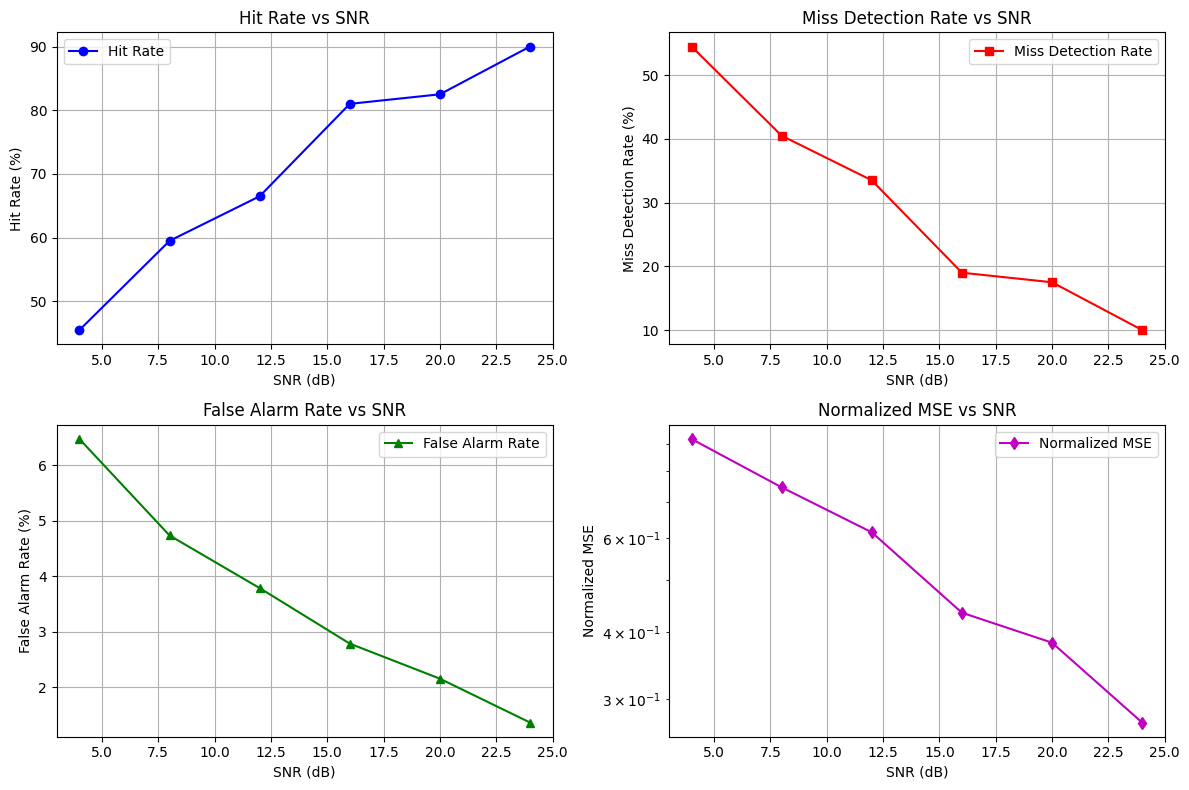

In [60]:
import matplotlib.pyplot as plt

# Define the SNR values for x-axis
snr_values = snr_db_array

# Create subplots for different performance metrics
plt.figure(figsize=(12, 8))

# Plot Hit Rate
plt.subplot(2, 2, 1)
plt.plot(snr_values, avg_hit_rate_casbl, marker='o', linestyle='-', color='b', label='Hit Rate')
plt.xlabel("SNR (dB)")
plt.ylabel("Hit Rate (%)")
plt.title("Hit Rate vs SNR")
plt.grid(True)
plt.legend()

# Plot Miss Detection Rate
plt.subplot(2, 2, 2)
plt.plot(snr_values, avg_miss_detection_rate_casbl, marker='s', linestyle='-', color='r', label='Miss Detection Rate')
plt.xlabel("SNR (dB)")
plt.ylabel("Miss Detection Rate (%)")
plt.title("Miss Detection Rate vs SNR")
plt.grid(True)
plt.legend()

# Plot False Alarm Rate
plt.subplot(2, 2, 3)
plt.plot(snr_values, avg_false_alarm_rate_casbl, marker='^', linestyle='-', color='g', label='False Alarm Rate')
plt.xlabel("SNR (dB)")
plt.ylabel("False Alarm Rate (%)")
plt.title("False Alarm Rate vs SNR")
plt.grid(True)
plt.legend()

# Plot Normalized MSE
plt.subplot(2, 2, 4)
plt.plot(snr_values, avg_norm_mse_casbl, marker='d', linestyle='-', color='m', label='Normalized MSE')
plt.xlabel("SNR (dB)")
plt.ylabel("Normalized MSE")
plt.title("Normalized MSE vs SNR")
plt.yscale('log')  # Log scale for better visualization
plt.grid(True)
plt.legend()

# Adjust layout and show the plots
plt.tight_layout()
plt.show()


In [61]:
import matplotlib.pyplot as plt
import numpy as np

def plot_casbl_vs_ground_truth(casbl_results, Z, sample_index, snr_index, snr_value):
    """Plot casbl reconstructed signal vs ground truth (Z) for a single sample at a given SNR."""
    plt.figure(figsize=(10, 5))

    # Ground truth (Z)
    plt.plot(np.abs(Z[sample_index,:,0]), marker='s', linestyle='--', color='g', label="Ground Truth (Z)")

    # casbl Estimated Signal
    plt.plot(np.abs(casbl_results[sample_index, snr_index, :, 0]), marker='o', linestyle='-', color='b', label="casbl Estimate")

    plt.xlabel("Device Index")
    plt.ylabel("Magnitude of Signal")
    plt.title(f"casbl vs. Ground Truth (Sample {sample_index}, SNR {snr_value} dB)")
    plt.legend()
    plt.grid(True)
    plt.show()

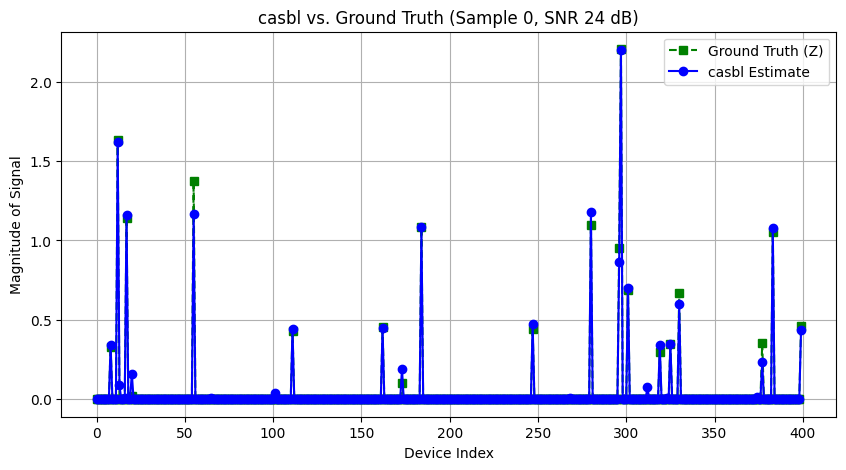

In [62]:
sample_index = 0  # Choose a specific sample
snr_index = 5  # Choose a specific SNR index
snr_value = snr_db_array[snr_index]

plot_casbl_vs_ground_truth(Z_casbl, all_Z, sample_index, snr_index, snr_value)

In [63]:
import matplotlib.pyplot as plt
import numpy as np

def plot_gamma_casbl_vs_ground_truth(gamma_casbl, gamma_true, sample_index, snr_index, snr_value):
    """Plot casbl estimated gamma vs ground truth gamma for a single sample at a given SNR."""
    plt.figure(figsize=(10, 5))

    device_indices = np.arange(len(gamma_true[sample_index]))  # X-axis: Device indices

    # Plot ground truth gamma (binary)
    plt.stem(device_indices, gamma_true[sample_index], linefmt='g--', markerfmt='gs', basefmt=" ", label="Ground Truth (γ)")

    # Plot casbl estimated gamma
    plt.stem(device_indices, gamma_casbl[sample_index, snr_index], linefmt='b-', markerfmt='bo', basefmt=" ", label="casbl Estimate (γ)")

    plt.xlabel("Device Index")
    plt.ylabel("Activity Indicator (0=Inactive, 1=Active)")
    plt.title(f"Device Activity (casbl vs. Ground Truth) - Sample {sample_index}, SNR {snr_value} dB")
    plt.legend()
    plt.grid(True)
    plt.show()


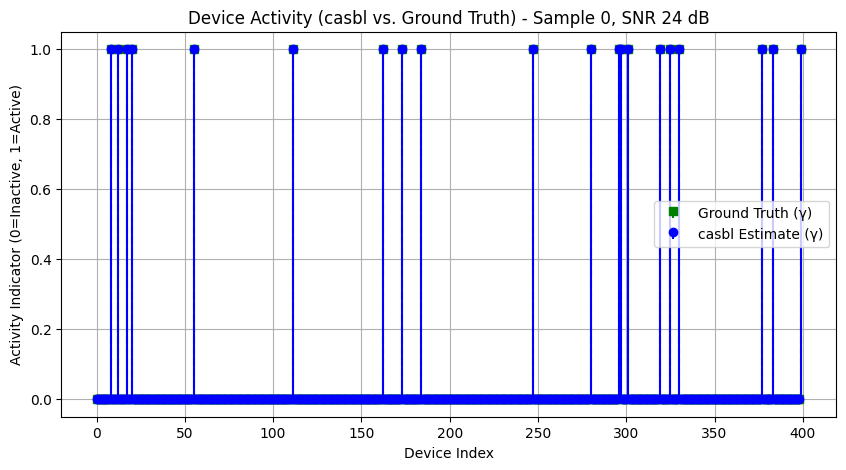

In [64]:
sample_index = 0  # Choose a specific sample
snr_index = 5  # Choose a specific SNR index
snr_value = snr_db_array[snr_index]

plot_gamma_casbl_vs_ground_truth(gamma_casbl, all_gamma, sample_index, snr_index, snr_value)